In [1]:
# DS ML-11 Assignment 031119

In [2]:
# Make ARIMA model over shampo sales data and check the MSE between 
# predicted adn actual value

In [20]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [21]:
def parser(x):
    return datetime.strptime('190'+x, "%Y-%m")

In [22]:
import numpy as np
import pandas as pd
from subprocess import check_output

In [23]:
from pandas import read_table
df = read_table('/Users/starlord/Downloads/sales shampoo.csv',sep=',')
df[:10]

/Users/starlord/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


,Month,Sales of shampoo over a three year period
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3
5,1-06,168.5
6,1-07,231.8
7,1-08,224.5
8,1-09,192.8
9,1-10,122.9


In [24]:
df['Month'] = "2018-" + df['Month']
df = df[:-1]
df

,Month,Sales of shampoo over a three year period
0,2018-1-01,266.0
1,2018-1-02,145.9
2,2018-1-03,183.1
3,2018-1-04,119.3
4,2018-1-05,180.3
5,2018-1-06,168.5
6,2018-1-07,231.8
7,2018-1-08,224.5
8,2018-1-09,192.8
9,2018-1-10,122.9


In [25]:
df.Month = pd.to_datetime(df.Month, format='%Y-%m-%d')


In [17]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib
# be able to save images on server
#matplotlib.use('Agg')
from matplotlib import pyplot
import numpy

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	return df



# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
	new_row = [x for x in X] + [yhat]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
	# separate
	X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
	# reshape
	reshaped = X.reshape(len(X), 1, 1)
	# forecast dataset
	output = model.predict(reshaped, batch_size=batch_size)
	# invert data transforms on forecast
	predictions = list()
	for i in range(len(output)):
		yhat = output[i,0]
		# invert scaling
		yhat = invert_scale(scaler, X[i], yhat)
		# invert differencing
		yhat = yhat + raw_data[i]
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
	# reset model state
	model.reset_states()
	return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# prepare model
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit model
	train_rmse, test_rmse = list(), list()
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
		# evaluate model on train data
		raw_train = raw[-(len(train)+len(test)+1):-len(test)]
		train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
		# evaluate model on test data
		raw_test = raw[-(len(test)+1):]
		test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
	history = DataFrame()
	history['train'], history['test'] = train_rmse, test_rmse
	return history

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

Using TensorFlow backend.


1) TrainRMSE=58.992881, TestRMSE=89.352182
2) TrainRMSE=61.981259, TestRMSE=104.982258
3) TrainRMSE=62.422800, TestRMSE=95.415038
4) TrainRMSE=66.053567, TestRMSE=100.668731
5) TrainRMSE=59.562077, TestRMSE=95.759170
6) TrainRMSE=66.295932, TestRMSE=100.817814
7) TrainRMSE=57.065940, TestRMSE=95.882984
8) TrainRMSE=61.348837, TestRMSE=99.809668
9) TrainRMSE=63.520388, TestRMSE=100.005557
10) TrainRMSE=64.384721, TestRMSE=98.033107


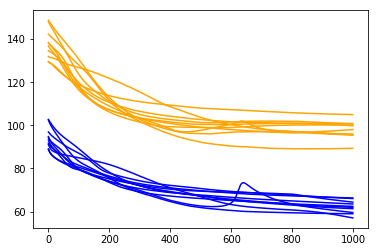

In [18]:
# config
n_lag = 1
n_repeats = 10
n_epochs = 1000 
n_batch = 4
n_neurons = 3
# load dataset
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# transform data to be stationary
#print(series.values)
raw_values = df['Sales of shampoo over a three year period'].values
diff_values = difference(raw_values, 1)
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, n_lag)
supervised_values = supervised.values[n_lag:,:]
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
# fit and evaluate model
train_trimmed = train_scaled[2:, :]
# run diagnostic tests
for i in range(n_repeats):
    history = fit_lstm(train_trimmed, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
    pyplot.plot(history['train'], color='blue')
    pyplot.plot(history['test'], color='orange')
    print('%d) TrainRMSE=%f, TestRMSE=%f' % (i+1, history['train'].iloc[-1], history['test'].iloc[-1]))
pyplot.savefig('diagnostic_baseline.png')